In [1]:
import os
import sys
sys.path.append("./..")
from utils import PROJECT_ROOT, process_Danenberg_clinical_data
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import networkx as nx
from matplotlib.lines import Line2D
import pandas as pd
from c_Population_graph.population_graph import construct_PopulationGraph
from d_Patient_subgroups.community_detection import detect_communities
from e_Survival_analysis.survival_analysis import calculate_hazard_ratio
from lifelines import CoxPHFitter, KaplanMeierFitter
from lifelines.statistics import multivariate_logrank_test, logrank_test

In [2]:
iteration = 2
PhenoGraph_k =  100
node_label = 'CellType'
size_smallest_cluster  = 10
survival_type = 'Disease-specific'
PopulationGraph_type = 'two_step_knn_graph'
para_dict = {
    'weight_threshold_percentile': 95,
    'knn_k': 30
}
knn_k = 5
patient_filtering_dict = {}

### Discovery

In [3]:
SoftWL_dict= pickle.load(
    open(
        os.path.join(
            PROJECT_ROOT,
            "Output",
            "b_Soft_WL_Kernel_random_split",
            "Danenberg",
            "Subset_1",
            "SoftWL_dict_iter_"
            + str(iteration)
            + "_PhenoGraph_k_"
            + str(PhenoGraph_k)
            + "_"
            + node_label
            + ".pkl",
        ),
        "rb",
    ),
)
Patient_IDs = SoftWL_dict["Patient_id"]
Gram_matrix = SoftWL_dict["Gram_matrix"]
Histograms = SoftWL_dict["Histogram"]
Histograms = Histograms/np.sum(Histograms, axis=1, keepdims=True)

clinical = pd.read_csv(
    os.path.join(
        PROJECT_ROOT,
        "Input",
        "Clinical",
        "Danenberg",
        "clinical.csv",
    )
)
clinical = process_Danenberg_clinical_data(clinical)
Patient_Inclusion_mask = np.ones(len(Patient_IDs), dtype=bool)
for feature, included_values in patient_filtering_dict.items():
    Feature = [clinical.loc[clinical['patient_id'] == patient_id, feature].values[0] for patient_id in Patient_IDs]
    patient_inclusion_mask = np.array([feature  == included_values for feature in Feature])
    Patient_Inclusion_mask = Patient_Inclusion_mask * patient_inclusion_mask
Patient_IDs = np.array(Patient_IDs)[Patient_Inclusion_mask]
Gram_matrix = Gram_matrix[Patient_Inclusion_mask, :][:, Patient_Inclusion_mask]
Histograms = Histograms[Patient_Inclusion_mask, :]
print("{} patients are included".format(len(Patient_IDs)))

G_population = construct_PopulationGraph(
    Gram_matrix,
    PopulationGraph_type,
    para_dict = para_dict,
)

Community_ids = detect_communities(G_population, size_smallest_cluster, resolution = 1)

Length = [clinical.loc[clinical['patient_id'] == i, survival_type+ ' Survival (Months)'].values[0] for i in Patient_IDs]
Status = [clinical.loc[clinical['patient_id'] == i,  survival_type+ ' Survival Status'].values[0] for i in Patient_IDs]  
DF = pd.DataFrame({"Length": Length, "Status": Status, "Community_ids": Community_ids}).dropna()
Length_ = np.array(DF["Length"])
Status_ = np.array(DF["Status"])
Community_ids_ = np.array(DF["Community_ids"])
Histograms_ = Histograms[DF.index.values, :]
Patient_IDs_ = np.array(Patient_IDs)[DF.index.values]
print("{} patients are included".format(len(Patient_IDs_)))
HR = calculate_hazard_ratio(Length_, Status_, Community_ids_)
HR = sorted(HR, key=lambda x: x["hr"], reverse=True)
Subgroup_ids_ = np.zeros_like(Community_ids_)
for i in range(len(HR)):
    Subgroup_ids_[Community_ids_ == HR[i]["community_id"]] = i + 1
    HR[i]["subgroup_id"] = i + 1
for i in range(len(HR)):
    print("S{} (N = {}):".format(HR[i]['subgroup_id'], np.sum(Subgroup_ids_ == HR[i]['subgroup_id'])))
    print("Survival: hr = {}, p = {}".format(HR[i]["hr"], HR[i]["p"]))
    if HR[i]["p"] < 0.05/len(HR):
        print("\tSignificant")

def caculate_mutual_similarity(gram_matrix):
    gram_matrix_ = gram_matrix.copy()
    np.fill_diagonal(gram_matrix_, -1)
    return np.mean(gram_matrix_[gram_matrix_!=-1])
for i in range(1, int(np.max(Community_ids)+1)):
    Gram_matrix_ = Gram_matrix[Community_ids == i, :][:, Community_ids == i]
    # if caculate_mutual_similarity(Gram_matrix_) < 2* caculate_mutual_similarity(Gram_matrix):
    #     Community_ids[Community_ids == i] = 0
    print("{} subgroup {} patients, averaged Intra-group similarity is {:.2f} ".format(Gram_matrix_.shape[0], i, caculate_mutual_similarity(Gram_matrix_)))

print("Overall {} patients, averaged Intra-group similarity is {:.2f} ".format(Gram_matrix.shape[0], caculate_mutual_similarity(Gram_matrix)))

379 patients are included
379 patients are included
S1 (N = 26):
Survival: hr = 2.428013562030345, p = 0.0009529780614233097
	Significant
S2 (N = 48):
Survival: hr = 1.6715184635587368, p = 0.02843447397812587
S3 (N = 23):
Survival: hr = 1.1993259620126575, p = 0.6188721644067485
S4 (N = 73):
Survival: hr = 1.1496241238841327, p = 0.5148989278165488
S5 (N = 61):
Survival: hr = 0.9672335783354061, p = 0.8872245985054152
S6 (N = 51):
Survival: hr = 0.6150989479810047, p = 0.12382629829932304
S7 (N = 97):
Survival: hr = 0.514502885809581, p = 0.005382388188832714
	Significant
97 subgroup 1 patients, averaged Intra-group similarity is 0.37 
73 subgroup 2 patients, averaged Intra-group similarity is 0.45 
61 subgroup 3 patients, averaged Intra-group similarity is 0.32 
51 subgroup 4 patients, averaged Intra-group similarity is 0.61 
48 subgroup 5 patients, averaged Intra-group similarity is 0.26 
26 subgroup 6 patients, averaged Intra-group similarity is 0.75 
23 subgroup 7 patients, averag

### Validation

In [4]:
def map_subgroup(Reference_label,similarity_query_reference, k = 3):
    Label_query_hat = np.zeros((similarity_query_reference.shape[0]))
    # Reference_label = Subgroup_ids_
    # Reference_label = np.zeros_like(Subgroup_ids_)
    # Reference_label[Subgroup_ids_ == 1] = 1
    # Reference_label[Subgroup_ids_ == 2] = 2
    # Reference_label[Subgroup_ids_ == 7] = 7
    # knn_classifier

    for i in range(similarity_query_reference.shape[0]):
        knn_similarity = np.sort(similarity_query_reference[i, :])[::-1][:k]
        if k == -1:
            k = len(knn_similarity)
        knn_community = Reference_label[
                np.argsort(similarity_query_reference[i, :])[::-1][:k]
            ]
        unqiue, _ = np.unique(knn_community, return_counts=True)
        Similarity = np.zeros_like(unqiue)
        for j in range(len(unqiue)):
            Similarity[j] = np.sum(knn_similarity[knn_community == unqiue[j]])
            if k == -1:
                Similarity[j] = np.mean(knn_similarity[knn_community == unqiue[j]])
                # print(unqiue[j], Similarity[j])
        Label_query_hat[i] = unqiue[np.argmax(Similarity)]
    return Label_query_hat

#### Jackson

In [5]:
from utils import process_Jackson_clinical_data
from b_Soft_WL_Kernel_random_split.SoftWL import get_Gram_matrix
survival_type_jackson = "Overall"
SoftWL_dict_jackson = pickle.load(
    open(
        os.path.join(
            PROJECT_ROOT,
            "Output",
            "b_Soft_WL_Kernel_random_split",
            "Jackson",
            "Matched_SoftWL_dict_iter_"
            + str(iteration)
            + "_PhenoGraph_k_"
            + str(PhenoGraph_k)
            + "_"
            + node_label
            + "_centroid_alignment.pkl",
        ),
        "rb",
    ),
)
Patient_IDs_jackson = SoftWL_dict_jackson["Patient_id"]
Histograms_jackson = SoftWL_dict_jackson["Histogram"]
Histograms_jackson = Histograms_jackson/np.sum(Histograms_jackson, axis=1, keepdims=True)
clinical = pd.read_csv(
    os.path.join(
        PROJECT_ROOT,
        "Input",
        "Clinical",
        "Jackson",
        "clinical.csv",
    )
)
clinical = process_Jackson_clinical_data(clinical)

Patient_Inclusion_mask_jackson = np.ones(len(Patient_IDs_jackson), dtype=bool)
for feature, included_values in patient_filtering_dict.items():
    Feature = [clinical.loc[clinical['patient_id'] == patient_id, feature].values[0] for patient_id in Patient_IDs_jackson]
    patient_inclusion_mask_jackson = np.array([feature  == included_values for feature in Feature])
    Patient_Inclusion_mask_jackson = Patient_Inclusion_mask_jackson * patient_inclusion_mask_jackson
Patient_IDs_jackson = np.array(Patient_IDs_jackson)[Patient_Inclusion_mask_jackson]
Histograms_jackson = Histograms_jackson[Patient_Inclusion_mask_jackson, :]

Length_jackson = [
        clinical.loc[clinical["patient_id"] == i, survival_type_jackson+" Survival (Months)"].values[0]
        for i in Patient_IDs_jackson
    ]
Status_jackson = [
        clinical.loc[clinical["patient_id"] == i, survival_type_jackson+" Survival Status"].values[0]
        for i in Patient_IDs_jackson
    ]

DF_jackson = pd.DataFrame({"Length": Length_jackson, "Status": Status_jackson}).dropna()
Length_jackson_ = np.array(DF_jackson["Length"])
Status_jackson_ = np.array(DF_jackson["Status"])
Histograms_jackson_ = Histograms_jackson[DF_jackson.index.values, :]
Patient_IDs_jackson_ = np.array(Patient_IDs_jackson)[DF_jackson.index.values]
print(len(Patient_IDs_jackson_))

Gram_matrix_jackson_ = get_Gram_matrix(Histograms_jackson_)
Similarity_jackson_discovery = get_Gram_matrix(
    np.concatenate([Histograms_jackson_, Histograms_], axis=0)
)
Similarity_jackson_discovery = Similarity_jackson_discovery[
    : Histograms_jackson_.shape[0], :
][:, Histograms_jackson_.shape[0] :]

Label_query_hat = map_subgroup(Subgroup_ids_,Similarity_jackson_discovery, k = 3)

266


/cis/home/zwang/venv/cell-gnn/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


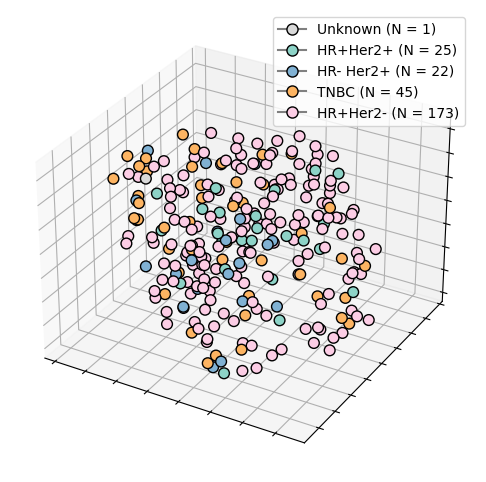

In [6]:
G_population = construct_PopulationGraph(
    Gram_matrix_jackson_,
    'two_step_knn_graph',
    para_dict = {
        'weight_threshold_percentile': 90,
        'knn_k':20
    },
)
Clinical_subtypes_ = np.array([clinical.loc[clinical['patient_id'] == patient_id, 'Clinical Subtype'].values[0] for patient_id in Patient_IDs_jackson_])
pos = nx.spring_layout(
    G_population, seed=100, k=1 / (np.sqrt(397)) * 10, iterations=100, dim=3
)
Clinical_subtype_id = np.array([0] * len(Clinical_subtypes_))
Clinical_subtype_id[Clinical_subtypes_ == "HR+/HER2-"] = 4
Clinical_subtype_id[Clinical_subtypes_ == "HR+/HER2+"] = 1
Clinical_subtype_id[Clinical_subtypes_ == "HR-/HER2+"] = 2
Clinical_subtype_id[Clinical_subtypes_ == "TNBC"] = 3
color_palette = [sns.color_palette("Set3")[8]] + [sns.color_palette("Set3")[0] ] +[sns.color_palette("Set3")[4] ] + [sns.color_palette("Set3")[5]] + [sns.color_palette("Set3")[7]]

fig = plt.figure(figsize=(6,6), tight_layout=True)
ax = fig.add_subplot(111, projection="3d")
node_xyz = np.array([pos[v] for v in sorted(G_population)])
edge_xyz = np.array([(pos[u], pos[v]) for u, v in G_population.edges()])
ax.scatter(
    *node_xyz.T,
    s=60,
    c=[color_palette[int(i)] for i in Clinical_subtype_id],
    # # c= 'white',
    edgecolors="black",
    linewidths=1,
    alpha=1
)
edge_list = list(G_population.edges())
edge_alpha = [
    0.2*G_population[u][v]["weight"] if G_population[u][v]["weight"] > 0.1 else 0
    for u, v in edge_list
]
# for i in range(len(edge_list)):
#     u, v = edge_list[i]
#     ax.plot(*edge_xyz[i].T, alpha=edge_alpha[i], color='k')

ax.set(
    xlim=(np.min(node_xyz[:, 0]), np.max(node_xyz[:, 0])),
    ylim=(np.min(node_xyz[:, 1]), np.max(node_xyz[:, 1])),
    zlim=(np.min(node_xyz[:, 2]), np.max(node_xyz[:, 2])),
)

handles = [
    Line2D(
        [0],
        [0],
        marker="o",
        color='grey',
        markerfacecolor=color_palette[0],
        label="Unknown (N = {})".format(np.sum(Clinical_subtype_id == 0)),
        markeredgecolor="black",
        markeredgewidth=1,
        markersize=8,
    ),
    Line2D(
        [0],
        [0],
        marker="o",
        color='grey',
        markerfacecolor=color_palette[1],
        label="HR+Her2+ (N = {})".format(np.sum(Clinical_subtypes_ == "HR+/HER2+")),
        markeredgecolor="black",
        markeredgewidth=1,
        markersize=8,
    ),
    Line2D(
        [0],
        [0],
        marker="o",
        color='grey',
        markerfacecolor=color_palette[2],
        label="HR- Her2+ (N = {})".format(np.sum(Clinical_subtypes_ == "HR-/HER2+")),
        markeredgecolor="black",
        markeredgewidth=1,
        markersize=8,
    ),
    Line2D(
        [0],
        [0],
        marker="o",
        color='grey',
        markerfacecolor=color_palette[3],
        label="TNBC (N = {})".format(np.sum(Clinical_subtypes_ == "TNBC")),
        markeredgecolor="black",
        markeredgewidth=1,
        markersize=8,
    ),
        Line2D(
        [0],
        [0],
        marker="o",
        color='grey',
        markerfacecolor=color_palette[4],
        label="HR+Her2- (N = {})".format(np.sum(Clinical_subtypes_ == "HR+/HER2-")),
        markeredgecolor="black",
        markeredgewidth=1,
        markersize=8,
    ),



]
ax.legend(handles=handles, fontsize = 10)
ax.set(yticklabels=[], xticklabels=[], zticklabels=[])
plt.show()

In [7]:
def caculate_mutual_similarity(gram_matrix):
    gram_matrix_ = gram_matrix.copy()
    np.fill_diagonal(gram_matrix_, -1)
    return np.mean(gram_matrix_[gram_matrix_!=-1])
Gram_matrix_ = Gram_matrix_jackson_[np.array(np.where(Clinical_subtypes_ == 'TNBC')[0].tolist()), :][:, np.array(np.where(Clinical_subtypes_ == 'TNBC')[0].tolist())]
print("{} TNBC patients, averaged Intra-group similarity is {:.2f} ".format(Gram_matrix_.shape[0], caculate_mutual_similarity(Gram_matrix_)))
Gram_matrix_ = Gram_matrix_jackson_[np.array(np.where(Clinical_subtypes_ == 'HR+/HER2-')[0].tolist()), :][:, np.array(np.where(Clinical_subtypes_ == 'HR+/HER2-')[0].tolist())]
print("{} 'HR+/HER2-' patients, averaged Intra-group similarity is {:.2f} ".format(Gram_matrix_.shape[0], caculate_mutual_similarity(Gram_matrix_)))
Gram_matrix_ = Gram_matrix_jackson_[np.array(np.where(Clinical_subtypes_ == 'HR+/HER2+')[0].tolist()), :][:, np.array(np.where(Clinical_subtypes_ == 'HR+/HER2+')[0].tolist())]
print("{} 'HR+/HER2+' patients, averaged Intra-group similarity is {:.2f} ".format(Gram_matrix_.shape[0], caculate_mutual_similarity(Gram_matrix_)))
Gram_matrix_ = Gram_matrix_jackson_[np.array(np.where(Clinical_subtypes_ == 'HR-/HER2+')[0].tolist()), :][:, np.array(np.where(Clinical_subtypes_ == 'HR-/HER2+')[0].tolist())]
print("{} 'HR-/HER2+' patients, averaged Intra-group similarity is {:.2f} ".format(Gram_matrix_.shape[0], caculate_mutual_similarity(Gram_matrix_)))
print("{} Overall patients, averaged Intra-group similarity is {:.2f} ".format(Gram_matrix_jackson_.shape[0], caculate_mutual_similarity(Gram_matrix_jackson_)))

45 TNBC patients, averaged Intra-group similarity is 0.28 
173 'HR+/HER2-' patients, averaged Intra-group similarity is 0.30 
25 'HR+/HER2+' patients, averaged Intra-group similarity is 0.33 
22 'HR-/HER2+' patients, averaged Intra-group similarity is 0.33 
266 Overall patients, averaged Intra-group similarity is 0.29 


Clinical Subtype: HR+/HER2+, Subgroup: 1, correlation_coefficient: 0.23, p_val: 1.36e-04


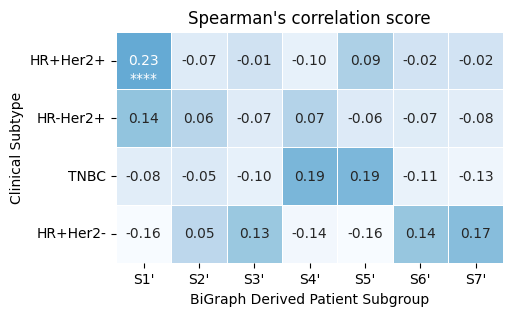

In [43]:
import numpy as np
from scipy.stats import chi2_contingency
from scipy.stats import spearmanr


spearmanr_corr = np.zeros((4, int(np.max(Label_query_hat))))
P_value = np.zeros((4, int(np.max(Label_query_hat))))
for clinical_subtype in ["HR+/HER2+", "HR-/HER2+", "TNBC", "HR+/HER2-"]:
    for subgroup_id in range(1, int(np.max(Label_query_hat) + 1)):
        variable_1 = (np.array(Clinical_subtypes_) == clinical_subtype) 
        variable_2 = (np.array(Label_query_hat) == subgroup_id)
        correlation_coefficient, p_value = spearmanr(variable_1, variable_2)
        spearmanr_corr[["HR+/HER2+", "HR-/HER2+", "TNBC", "HR+/HER2-"].index(clinical_subtype), subgroup_id-1] = correlation_coefficient
        P_value[["HR+/HER2+", "HR-/HER2+", "TNBC", "HR+/HER2-"].index(clinical_subtype), subgroup_id-1] = p_value
        if p_value < 1E-3:
            # print(0.05/35)
            # print(observed_data)
            # print(expected)
            print(
                    "Clinical Subtype: {}, Subgroup: {}, correlation_coefficient: {:.2f}, p_val: {:.2e}".format(
                        clinical_subtype, subgroup_id, correlation_coefficient, p_value
                    )
                )

       
f, ax = plt.subplots(figsize=(5, 3))
sns.heatmap(spearmanr_corr, annot=True, fmt=".2f", cmap="Blues", cbar = False, linewidths=0.5, linecolor='white', ax=ax,vmax= 0.6)
ax.text(0 + 0.5, 0+0.8 , '****',
                 horizontalalignment='center',
                 verticalalignment='center',
                 color = 'white'
                 )
# ax.text(0 + 0.5, 1+0.8 , '****',
#                  horizontalalignment='center',
#                  verticalalignment='center',
#                  color = 'white'
#                  )
# ax.text(0 + 0.5, 3+0.8 , '****',
#                  horizontalalignment='center',
#                  verticalalignment='center',
#                  color = 'black'
#                  )

# ax.text(1 + 0.5, 2+0.8 , '****',
#                  horizontalalignment='center',
#                  verticalalignment='center',
#                  color = 'white'
#                  )
# ax.text(3 + 0.5, 2+0.8 , '****',
#                  horizontalalignment='center',
#                  verticalalignment='center',
#                  color = 'white'
#                  )

# ax.text(6 + 0.5, 3+0.8 , '***',
#                  horizontalalignment='center',
#                  verticalalignment='center',
#                  color = 'white'
                #  )
#         # ax.text(x + 0.5, y+0.8 , '****',
#         #          horizontalalignment='center',
#         #          verticalalignment='center',
#         #          )


ax.set_xlabel("BiGraph Derived Patient Subgroup")
ax.set_ylabel("Clinical Subtype")
ax.set_xticklabels(['S'+str(i)+"'" for i in range(1, int(np.max(Subgroup_ids_)+1))] ,rotation=0)
ax.set_yticklabels(["HR+Her2+", "HR-Her2+", "TNBC", "HR+Her2-"], rotation=0)
ax.set(title = "Spearman's correlation score")
plt.show()

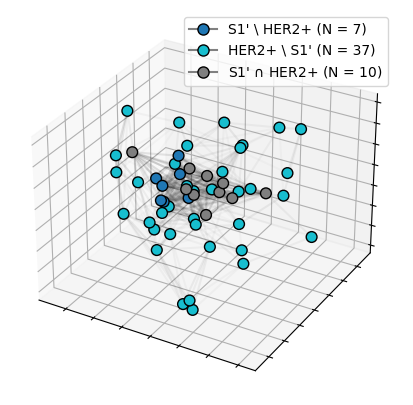

In [29]:
subgroup_id = 1
clinical_subtype = "HER2+"

color_palette_clinical = {
    'HR+/HER2+': sns.color_palette("Set3")[0],
    'HR-/HER2+': sns.color_palette("Set3")[4],
    'HER2+':sns.color_palette("tab10")[9],
    'TNBC': sns.color_palette("Set3")[5],
    'HR+/HER2-': sns.color_palette("Set3")[7],
}
color_palette_Bigraph = {
    1: sns.color_palette("tab10")[0],
    2: sns.color_palette("tab10")[1],
    3: sns.color_palette("tab10")[2],
    4: sns.color_palette("tab10")[3],
    5: sns.color_palette("tab10")[4],
    6: sns.color_palette("tab10")[5],
    7: sns.color_palette("tab10")[6],
}



Clinical_subtypes_[Clinical_subtypes_ == 'HR+/HER2+'] = 'HER2+'
Clinical_subtypes_[Clinical_subtypes_ == 'HR-/HER2+'] = 'HER2+'
G_population = construct_PopulationGraph(
    Gram_matrix_jackson_,
    'two_step_knn_graph',
    para_dict = {
        'weight_threshold_percentile': 90,
        'knn_k':20
    },
)
pos = nx.spring_layout(
    G_population, seed=100, k=1 / (np.sqrt(397)) * 10, iterations=100, dim=3
)
node_xyz = np.array([pos[v] for v in sorted(G_population)])
edge_xyz = np.array([(pos[u], pos[v]) for u, v in G_population.edges()])
edge_list = list(G_population.edges())
edge_alpha = [
    0.2*G_population[u][v]["weight"] if G_population[u][v]["weight"] > 0.1 else 0
    for u, v in edge_list
]

fig = plt.figure(figsize=(5,5), tight_layout=True)

Colors = []
for i in range(len(Patient_IDs_jackson_)):
    if Clinical_subtypes_[i] == clinical_subtype and Label_query_hat[i] == subgroup_id:
        Colors.append(sns.color_palette()[7])
    elif Label_query_hat[i] == subgroup_id:
        Colors.append(color_palette_Bigraph[subgroup_id])
    elif Clinical_subtypes_[i] == clinical_subtype:
        Colors.append(color_palette_clinical[clinical_subtype])
Indices_included = np.where((Clinical_subtypes_ == clinical_subtype) + (Label_query_hat == subgroup_id))[0]



ax = fig.add_subplot(111, projection="3d")
ax.scatter(
    *node_xyz.T[:, Indices_included],
    s=60,
    c=Colors,
    edgecolors="black",
    linewidths=1,
    alpha=1
)

for i in range(len(edge_list)):
    u, v = edge_list[i]
    if u in Indices_included and v in Indices_included:
        ax.plot(*edge_xyz[i].T, alpha=edge_alpha[i], color='k')

ax.set(
    xlim=(np.min(node_xyz[Indices_included, :][:, 0]), np.max(node_xyz[Indices_included, :][:, 0])),
    ylim=(np.min(node_xyz[Indices_included, :][:, 1]), np.max(node_xyz[Indices_included, :][:, 1])),
    zlim=(np.min(node_xyz[Indices_included, :][:, 2]), np.max(node_xyz[Indices_included, :][:, 2])),
)

handles = [

    Line2D(
        [0],
        [0],
        marker="o",
        color='grey',
        markerfacecolor=color_palette_Bigraph[subgroup_id],
        label=r"S{}' \ {} (N = {})".format(subgroup_id, clinical_subtype, np.sum((Clinical_subtypes_ != clinical_subtype) * (Label_query_hat == subgroup_id))),
        markeredgecolor="black",
        markeredgewidth=1,
        markersize=8,
    ),
    Line2D(
        [0],
        [0],
        marker="o",
        color='grey',
        markerfacecolor=color_palette_clinical[clinical_subtype],
        label=r"{} \ S{}' (N = {})".format(clinical_subtype, subgroup_id, np.sum((Clinical_subtypes_ == clinical_subtype) * (Label_query_hat != subgroup_id))),
        markeredgecolor="black",
        markeredgewidth=1,
        markersize=8,
    ),
    Line2D(
        [0],
        [0],
        marker="o",
        color='grey',
        markerfacecolor=sns.color_palette()[7],
        label=r"S{}' $\cap$ {} (N = {})".format(subgroup_id, clinical_subtype, np.sum((Clinical_subtypes_ == clinical_subtype) * (Label_query_hat == subgroup_id))),
        markeredgecolor="black",
        markeredgewidth=1,
        markersize=8,
    ),

 
 ]
ax.legend(handles=handles, fontsize = 10)
ax.set(yticklabels=[], xticklabels=[], zticklabels=[])

plt.show()

In [9]:
color_palette_clinical = {
    'HR+/HER2+': sns.color_palette("Set3")[0],
    'HR-/HER2+': sns.color_palette("Set3")[4],
    'HER2+':sns.color_palette("tab10")[9],
    'TNBC': sns.color_palette("Set3")[5],
    'HR+/HER2-': sns.color_palette("Set3")[7],
}
color_palette_Bigraph = {
    1: sns.color_palette("tab10")[0],
    2: sns.color_palette("tab10")[1],
    3: sns.color_palette("tab10")[2],
    4: sns.color_palette("tab10")[3],
    5: sns.color_palette("tab10")[4],
    6: sns.color_palette("tab10")[5],
    7: sns.color_palette("tab10")[6],
}


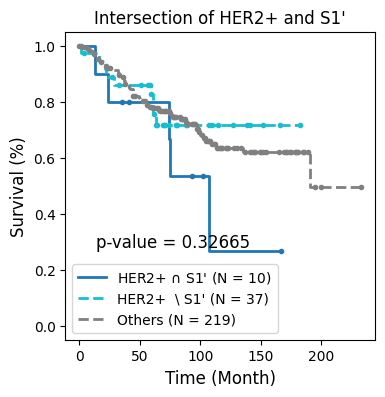

In [16]:
Clinical_subtypes_[Clinical_subtypes_ == 'HR+/HER2+'] = 'HER2+'
Clinical_subtypes_[Clinical_subtypes_ == 'HR-/HER2+'] = 'HER2+'
subgroup_id = 1
clinical_subtype = "HER2+"

f, ax = plt.subplots(figsize=(4, 4))
kmf = KaplanMeierFitter()

Indices_A = (Label_query_hat == subgroup_id) & (Clinical_subtypes_ == clinical_subtype)
length_A, event_observed_A = (
    Length_jackson_[Indices_A],
    Status_jackson_[Indices_A],
)
label = r"{} $\cap$ S{}' (N = {}) ".format(clinical_subtype, subgroup_id, len(length_A))
kmf.fit(length_A, event_observed_A, label=label)
kmf.plot_survival_function(
    ax=ax,
    ci_show=False,
    color=color_palette_Bigraph[subgroup_id],
    show_censors=True,
    censor_styles={"ms": 3, "marker": "o"},
    markerfacecolor="k",
    linewidth=2,
)
Indices_B = (Label_query_hat != subgroup_id) & (Clinical_subtypes_ == clinical_subtype)
length_B, event_observed_B = (
    Length_jackson_[Indices_B],
    Status_jackson_[Indices_B],
)
label = r"{}  \ S{}' (N = {})".format(clinical_subtype, subgroup_id, len(length_B))
kmf.fit(length_B, event_observed_B, label=label)
kmf.plot_survival_function(
    ax=ax,
    ci_show=False,
    color=color_palette_clinical[clinical_subtype],
    show_censors=True,
    censor_styles={"ms": 3, "marker": "o"},
    linestyle="--",
    linewidth=2,
)
Indices_C = Clinical_subtypes_ != clinical_subtype
length_C, event_observed_C = (
    Length_jackson_[Indices_C],
    Status_jackson_[Indices_C],
)
label = r"Others (N = {})".format(len(length_C))
kmf.fit(length_C, event_observed_C, label=label)
kmf.plot_survival_function(
    ax=ax,
    ci_show=False,
    color='grey',
    show_censors=True,
    censor_styles={"ms": 3, "marker": "o"},
    linestyle="--",
    linewidth=2,
)

Groups_ = np.zeros_like(Clinical_subtypes_, dtype=int)
Groups_[
    ((Clinical_subtypes_ == clinical_subtype)) & (Label_query_hat != subgroup_id)
] = 2
Groups_[
    ((Clinical_subtypes_ == clinical_subtype)) & (Label_query_hat == subgroup_id)
] = 3
log_rank_test = multivariate_logrank_test(Length_jackson_, Groups_, Status_jackson_)

ax.legend(fontsize=10)
ax.set_xlabel("Time (Month)", fontsize=12)
ax.set_ylabel("Survival (%)", fontsize=12)
ax.set(
    ylim=(-0.05, 1.05),
    title = 'Intersection of {} and {}'.format(clinical_subtype, 'S'+str(subgroup_id)+"'"),
)

ax.text(
    0.1,
    0.3,
    s="p-value = {:.5f}".format(log_rank_test.p_value),
    fontsize=12,
    transform=ax.transAxes,
)
plt.show()

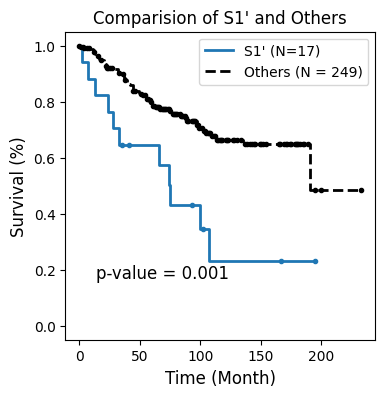

In [46]:
subgroup_id = 1
f, ax = plt.subplots(figsize=(4,4))
kmf = KaplanMeierFitter()
Indices_C = ( Label_query_hat== subgroup_id) 
length_C, event_observed_C = (
                Length_jackson_[Indices_C],
                Status_jackson_[Indices_C],
            )
label = r"S{}' (N={})".format(subgroup_id, len(length_C))
kmf.fit(length_C, event_observed_C, label=label)
kmf.plot_survival_function(ax=ax, ci_show=False, color=color_palette_Bigraph[subgroup_id],show_censors=True,censor_styles={"ms": 3, "marker": "o"},linewidth=2)



Indices_B = (Label_query_hat != subgroup_id) 
length_B, event_observed_B = (
                Length_jackson_[Indices_B],
                Status_jackson_[Indices_B],
            )
label = r'Others (N = {})'.format(len(length_B))
kmf.fit(length_B, event_observed_B, label=label)
kmf.plot_survival_function(ax=ax, ci_show=False, color='k',show_censors=True,censor_styles={"ms": 3, "marker": "o"}, linestyle = '--', linewidth=2)



Groups_ = np.zeros_like(Clinical_subtypes_, dtype=int)
Groups_[(Label_query_hat==subgroup_id)] = 1
Groups_[(Label_query_hat!=subgroup_id)] = 2
log_rank_test = multivariate_logrank_test(
        Length_jackson_,Groups_, Status_jackson_
    
)
ax.legend(fontsize = 10)
ax.set_xlabel("Time (Month)", fontsize = 12)
ax.set_ylabel("Survival (%)", fontsize = 12)
ax.set(
        ylim=(-0.05, 1.05),
    )
ax.set(title = "Comparision of S{}' and Others".format(subgroup_id))
ax.text(0.1,0.2, s = 'p-value = {:.3f}'.format(log_rank_test.p_value), fontsize = 12, transform=ax.transAxes)
plt.show()

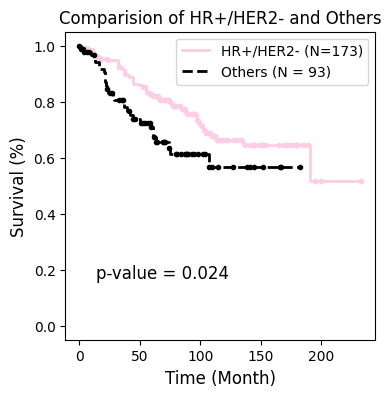

In [47]:

f, ax = plt.subplots(figsize=(4,4))
kmf = KaplanMeierFitter()
Indices_C = (Clinical_subtypes_ == clinical_subtype) 
length_C, event_observed_C = (
                Length_jackson_[Indices_C],
                Status_jackson_[Indices_C],
            )
label = r'{} (N={})'.format(clinical_subtype, len(length_C))
kmf.fit(length_C, event_observed_C, label=label)
kmf.plot_survival_function(ax=ax, ci_show=False, color=color_palette_clinical[clinical_subtype],show_censors=True,censor_styles={"ms": 3, "marker": "o"},linewidth=2)



Indices_B = (Clinical_subtypes_ != clinical_subtype) 
length_B, event_observed_B = (
                Length_jackson_[Indices_B],
                Status_jackson_[Indices_B],
            )
label = r'Others (N = {})'.format(len(length_B))
kmf.fit(length_B, event_observed_B, label=label)
kmf.plot_survival_function(ax=ax, ci_show=False, color='k',show_censors=True,censor_styles={"ms": 3, "marker": "o"}, linestyle = '--', linewidth=2)



Groups_ = np.zeros_like(Clinical_subtypes_, dtype=int)
Groups_[(Clinical_subtypes_==clinical_subtype)] = 1
Groups_[(Clinical_subtypes_!=clinical_subtype)] = 2
log_rank_test = multivariate_logrank_test(
        Length_jackson_,Groups_, Status_jackson_
    
)
ax.legend(fontsize = 10)
ax.set_xlabel("Time (Month)", fontsize = 12)
ax.set_ylabel("Survival (%)", fontsize = 12)
ax.set(
        ylim=(-0.05, 1.05),
    )
ax.set(title = "Comparision of {} and Others".format(clinical_subtype))
ax.text(0.1,0.2, s = 'p-value = {:.3f}'.format(log_rank_test.p_value), fontsize = 12, transform=ax.transAxes)
plt.show()